<a href="https://colab.research.google.com/github/ksydata/DB_FEC_CreditScoringSystem/blob/main/%5BNCB_MICE_FS%5D_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 은행과 같은 금융기관의 리테일 금융소비자(개인 고객)에 대하여 가계신용대출(Home Credit Loan)을 할 경우 **고객이 대출금을 상환할지 Target 변수 분류 및 대출금액 예측** 프로젝트


### 이상치 탐지 및 처리기준 수립

자주 일어나는 사건을 예측하거나 분류하기 위해 머신러닝 모델을 만들거나
통계적 가설검정을 하는 것만큼 중요한 것은,

가끔 일어나는 사건, 예를 들어 이상치를 탐지하는 전처리는 모델 성능이나
유의확률[검정 결과]에 영향을 미칠 만큼 중요함. (숙명여대, Chulyun Kim)

Noise는 random error로 이상치 탐지 **전** 제거해야 하는 데이터이며, Outlier(Novel / Anomaly Data)는 우리가 찾고자 하는 이상치를 말함. (고려대, Pilsung Kang)

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import missingno as msno
from typing import *
  # [데이터프레임 핸들링, 선형대수, 결측값 처리 목적 라이브러리 모듈]

from google.colab import drive
drive.mount("/content/drive")
  # [코랩에 구글 드라이브 마운트]

from sklearn.preprocessing import *
  # [연속형 변수 스케일링 및 범주형 변수 인코딩 목적 모든 라이브러리 모듈]
from sklearn.model_selection import train_test_split
  # [훈련용 및 검증용 데이터 셋 분할 목적 라이브러리 모듈]
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  # [K-폴드 교차검증(랜덤 또는 타겟하는 클래스 변수 비율 층화) 및 그리드 서치 목적 라이브러리 모듈]

import matplotlib.pyplot as plt
import seaborn as sns
  # [데이터 시각화 모듈]

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from scipy.spatial import distance
  # [distance.euclidean(x, y)]
from math import dist
  # [dist(x, y)]
from sklearn.neighbors import DistanceMetric
  # [이상치 탐지 목적 모듈]

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
  # [차원축소 후 2 또는 3차원 시각화 모듈]

from sklearn.metrics import *
  # [혼동행렬 등 분류모델 성능평가 모듈]

Mounted at /content/drive


In [ ]:
NCB_MICE_FS = pd.read_csv("/content/drive/MyDrive/NCB_MICE_NEW.csv", index_col = False)
  # [NA 대체, 범주형 변수 원핫인코딩, Feature Selection 완료된 데이터프레임 로드]

In [ ]:
NCB_MICE_FS = NCB_MICE_FS.drop("AMT_GOODS_PRICE_y", axis = 1)

In [ ]:
NCB_MICE_FS.head()

,AMT_ANNUITY_y,DAYS_EMPLOYED,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,DAYS_BIRTH,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,...,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,TARGET,AMT_CREDIT_x,AMT_CREDIT_y,SK_ID_CURR,SK_ID_PREV
0,9251.775,637,24700.5,179055.0,351000.0,9461,1,0,0,1,...,0,0,1,0,0,1,406597.5,179055.0,100002,1038818.0
1,64567.665,1188,35698.5,337500.0,1129500.0,16765,0,1,1,0,...,0,0,0,0,0,0,1293502.5,348637.5,100003,2636178.0
2,17885.835,1588,27517.5,162598.5,454500.0,16941,1,0,0,1,...,0,0,0,0,0,0,490495.5,162598.5,100008,2218188.0
3,8996.760,3130,41301.0,98239.5,1395000.0,13778,0,1,1,0,...,0,0,0,0,0,0,1560726.0,98239.5,100009,1413109.0
4,27463.410,449,42075.0,247212.0,1530000.0,18850,1,0,1,0,...,0,0,0,0,0,0,1530000.0,260811.0,100010,2349489.0


In [ ]:
NCB_MICE_FS.iloc[:, 0:30].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313975 entries, 0 to 313974
Data columns (total 30 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   AMT_ANNUITY_y                                      313975 non-null  float64
 1   DAYS_EMPLOYED                                      313975 non-null  int64  
 2   AMT_ANNUITY_x                                      313975 non-null  float64
 3   AMT_APPLICATION                                    313975 non-null  float64
 4   AMT_GOODS_PRICE_x                                  313975 non-null  float64
 5   DAYS_BIRTH                                         313975 non-null  int64  
 6   CODE_GENDER_M                                      313975 non-null  int64  
 7   CODE_GENDER_F                                      313975 non-null  int64  
 8   NAME_EDUCATION_TYPE_Higher education               313975 non-null  int64 



* NCB_MICE_FS

  New Credit Bureau

  MICE which impute NA to predictions generated by Random Forest model

  Feature Selected Version

* 범주형 변수는 더미 변수로 인코딩 완료하였으나 연속형 변수는 이상치 탐지, 판정, 처리를 위해 단위 스케일링을 수행하지 않은 데이터

In [ ]:
NCB_MICE_FS.iloc[:, 6:124] = NCB_MICE_FS.iloc[:, 6:124].astype("uint8")
  # [더미변수를 "64비트(8바이트)의 부호 있는 정수형"에서 "8비트(1바이트)의 부호 없는 정수형" 변환]
  # [메모리 공간 사용 영역을 줄이기 위한 목적]

In [ ]:
NCB_MICE_FS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313975 entries, 0 to 313974
Columns: 128 entries, DAYS_EMPLOYED to SK_ID_PREV
dtypes: float64(7), int64(3), uint8(118)
memory usage: 59.3 MB


In [ ]:
NCB_MICE_FS.size

40188800

In [ ]:
NCB_MICE_FS["duplicate"] = NCB_MICE_FS["SK_ID_CURR"].duplicated()

<ipython-input-8-57eb666f4bd6>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  NCB_MICE_FS["duplicate"] = NCB_MICE_FS["SK_ID_CURR"].duplicated()


In [ ]:
NCB_MICE_FS["duplicate"].value_counts()
    # [과거 ID인 SK_ID_PREV가 달라 신용대출을 중복하여 받은 이력이 있는 현재 ID인 SK_ID_CURR이 동일한 고객이 존재함]

False    178924
True     135051
Name: duplicate, dtype: int64

In [ ]:
NCB_MICE_FS["duplicate"] = NCB_MICE_FS["duplicate"].astype("uint8")
NCB_MICE_FS["duplicate"].value_counts()

0    178924
1    135051
Name: duplicate, dtype: int64

In [ ]:
# 연속형 독립변수 0 ~ 5, 125, 128열과 종속변수 123, 124열 상관관계 분석

correlation = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 123, 124, 125, 128]].corr()
  # [NCB_MICE_FS 데이터프레임의 Correlation Matrix]
mask = np.zeros_like(correlation, dtype = np.bool)
    # [상관분석 히트맵 삼각형 마스크(위 쪽 삼각형에 True, 아래 삼각형에 False)]
mask[np.triu_indices_from( mask )] = True

<ipython-input-11-4e1e78fc8299>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype = np.bool)


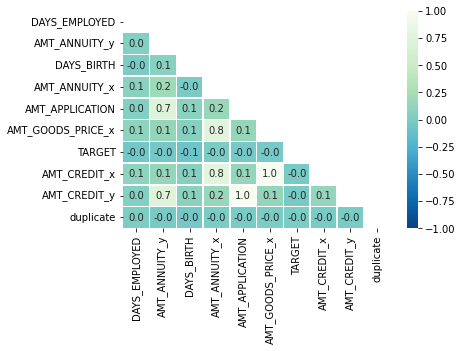

In [ ]:
# 상관계수 히트맵

sns.heatmap(data = correlation,
            cmap = "GnBu_r",
              # [colormap 팔레트]
            annot = True,
              # [실제값 표시]
            fmt = "0.01f",
              # [소수점 둘째 자리까지 표시]
            mask = mask,
              # [표시하지 않을 위쪽 삼각형 마스크 부분 지정]
            linewidths = 0.5,
              # [경계면 실선으로 구분]
            vmin = -1,
            vmax = 1
              # [colorbar의 범위 -1 ~ 1로 지정]
            )
plt.show()
  # [분류모델 종속변수 TARGET과 상관관계 있는 연속형 변수 無]
  # [회귀분석 종속변수 AMT_CREDIT_x와 상관관계 있는 연속형 변수] AMT_AUNNUITY_x, AMT_GOODS_PRICE_x

##### 4. 격리 포레스트(Isolated Forest, Global Outlier)


* NCB_Isolation의 IF_anomaly_score

  데이터 세트를 랜덤한 의사결정나무로 표현하여 이상치를 의사결정나무 상단 노드에서 분리하는(짧은 경로 길이를 생성하는) 밀도 기반의 이상치 탐지하는 알고리즘

  분류 모형을 생성하여 모든 관측치를 고립시켜 나가면서 분할 횟수로 이상치를 탐색하며, 모형에서 적은 횟수로 Leaf 노드에 도달하는 관측치일수록 이상치일 가능성이 크다고 판단

  각 샘플의 이상 점수를 반환

```
The novelty score s(x, n) = 2^( E(h(x))/c(n) )
  # [h(x)] 관측값 x의 경로 길이
  # [c(n)] 이진검색트리에서 실패한 검색의 평균 경로 길이
  # [n] 외부 노드의 수

  # [E(h(x)) = c(n)] s(x, n) = 0.5
  # [E(h(x)) = 0, s(x, n) = 1]
  # [E(h(x)) = n -1, s(x, n_ = 0]
```

  https://github.com/Albertsr/Anomaly-Detection/blob/master/UnSupervised-Isolation%20Forest/Isolation%20Forest.pdf

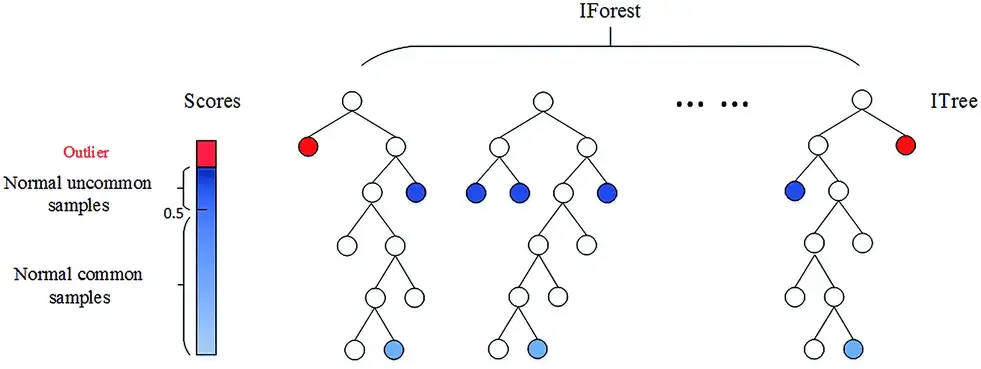

In [ ]:
x_train_outlier, x_test_outlier = 0, 0
x_train_outlier, x_test_outlier = train_test_split(NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 124, 125]],
                                                   test_size = 0.5,
                                                   random_state = 2022)
  # [비지도학습이므로 y 없다고 가정하고 데이터 분할]

In [ ]:
print(x_train_outlier.shape, x_test_outlier.shape)

(156987, 8) (156988, 8)


In [ ]:
cont = []
float = 0.0009

while float:
  if float < 0.005:
    float = float + 0.0001
    float = round(float, 5)
    cont.append(float)
  else:
    break

In [ ]:
print(cont, end = ",")

[0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003, 0.0031, 0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004, 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048, 0.0049, 0.005],

In [ ]:
np.random.seed(2040)

In [ ]:
# contamination 파라미터 기준 설정, 그리드서치

i = 0
i = []

for i in cont:
  globals()["isolation_outlier_{}".format(i)] = IsolationForest(n_estimators = 50,
                                                                 max_samples = 1000,
                                                                 contamination = i,
                                                                 max_features = 1.0,
                                                                 bootstrap = False,
                                                                 n_jobs = None,
                                                                 random_state = 2023,
                                                                 verbose = 0)
  globals()["isolation_outlier_fit_{}".format(i)] = globals()["isolation_outlier_{}".format(i)].fit(x_train_outlier)
  globals()["pred_test_{}".format(i)] = globals()["isolation_outlier_fit_{}".format(i)].predict(x_test_outlier)
  globals()["isolation_outlier_fit_test_{}".format(i)] = globals()["isolation_outlier_{}".format(i)].fit(x_test_outlier)
  globals()["refer_test_{}".format(i)] = globals()["isolation_outlier_fit_test_{}".format(i)].predict(x_test_outlier)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but I

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
g = 0
g = []

for g in cont :
  globals()["isolation_cf_{}".format(g)] = confusion_matrix(globals()["refer_test_{}".format(g)], globals()["pred_test_{}".format(g)])
      # [confusion_matirx] 함수는 음성이 양성보다 먼저 오는 형태가 디폴트로,
      #  TN [0,0] FP [0,1]
      #  FN [1,0] TP [1,1] 순서로 되어 있다.
      # 지금은 이상치인 -1(음성)을 주요 값으로 보고 혼동행렬을 해석해야 하므로
      # 디폴트 배열 순서에서 TN을 TP로 봐야 한다. (실제 이상치인 값들을 예측도 이상치라고 한 경우)
      #
      # [confusion_matrix]의 해석
      #   refer    pred
      #   TP [0,0] FN [0,1]
      #   FP [1,0] TN [1,1]
      #
      # 반면 [recall_score] 함수는 1(양성)을 디폴트로 계산하는 함수이므로
      # [pos_label = -1] 파라미터를 지정하여 -1(음성)을 주요 변수로 하는 재현율 값을 구해야 한다.


  print(g)
  print(globals()["isolation_cf_{}".format(g)])
  print("실제값 :", Counter(globals()["refer_test_{}".format(g)]))
  print("예측값 :", Counter(globals()["pred_test_{}".format(g)]))

  print("Calculate Recall", globals()["isolation_cf_{}".format(g)][0,0]/(globals()["isolation_cf_{}".format(g)][0,0]+globals()["isolation_cf_{}".format(g)][0, 1]))

  print("Scikit-Learn Recall :", recall_score(globals()["refer_test_{}".format(g)], globals()["pred_test_{}".format(g)], pos_label = -1))
  print("Scikit-Learn Precision :", precision_score(globals()["refer_test_{}".format(g)], globals()["pred_test_{}".format(g)], pos_label = -1))

0.001
[[   128     29]
 [    49 156782]]
실제값 : Counter({1: 156831, -1: 157})
예측값 : Counter({1: 156811, -1: 177})
Calculate Recall 0.8152866242038217
Scikit-Learn Recall : 0.8152866242038217
Scikit-Learn Precision : 0.7231638418079096
0.0011
[[   140     31]
 [    54 156763]]
실제값 : Counter({1: 156817, -1: 171})
예측값 : Counter({1: 156794, -1: 194})
Calculate Recall 0.8187134502923976
Scikit-Learn Recall : 0.8187134502923976
Scikit-Learn Precision : 0.7216494845360825
0.0012
[[   154     35]
 [    54 156745]]
실제값 : Counter({1: 156799, -1: 189})
예측값 : Counter({1: 156780, -1: 208})
Calculate Recall 0.8148148148148148
Scikit-Learn Recall : 0.8148148148148148
Scikit-Learn Precision : 0.7403846153846154
0.0013
[[   169     36]
 [    54 156729]]
실제값 : Counter({1: 156783, -1: 205})
예측값 : Counter({1: 156765, -1: 223})
Calculate Recall 0.824390243902439
Scikit-Learn Recall : 0.824390243902439
Scikit-Learn Precision : 0.757847533632287
0.0014
[[   181     39]
 [    55 156713]]
실제값 : Counter({1: 1567

In [ ]:
isolation_outlier = IsolationForest(n_estimators = 50,
                                    max_samples = 1000,
                                    contamination = 0.0014,
                                    max_features = 1.0,
                                    bootstrap = False,
                                    n_jobs = None,
                                    random_state = 2023,
                                    verbose = 0)
  # [50개 노드 수] [최대 1000개 샘플] [0.0014%의 이상치 색출(오염 정도)]

In [ ]:
isolation_outlier.fit(x_train_outlier)
  # [UserWarning] X does not have valid feature names, but IsolationForest was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.0014, max_samples=1000, n_estimators=50,
                random_state=2023)

In [ ]:
x_train_outlier

,DAYS_EMPLOYED,AMT_ANNUITY_y,DAYS_BIRTH,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_CREDIT_y
115367,2500,14910.930,19743,30528.0,135000.0,675000.0,942300.0,172206.0
296230,0,10748.835,21209,27810.0,45000.0,468000.0,542133.0,52366.5
76832,1534,13114.980,20621,57676.5,112500.0,675000.0,790830.0,119925.0
292226,2723,19884.690,18112,27171.0,103392.0,337500.0,373140.0,108850.5
70342,0,7627.545,22344,16096.5,41265.0,225000.0,331920.0,41265.0
...,...,...,...,...,...,...,...,...
202992,254,10418.940,7764,6750.0,93510.0,135000.0,135000.0,103383.0
262129,586,17447.490,11833,6012.0,161991.0,90000.0,90000.0,179095.5
103024,584,26491.050,12022,68512.5,279000.0,1800000.0,1971072.0,279000.0
147629,0,6735.870,18695,20250.0,33300.0,405000.0,405000.0,37075.5


In [ ]:
pred_train = isolation_outlier.predict(x_train_outlier)
pred_test = isolation_outlier.predict(x_test_outlier)

In [ ]:
isolation_outlier.fit(x_test_outlier)
refer_test = isolation_outlier.predict(x_test_outlier)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
x_train_outlier["IF_anomaly_score"] = pred_train
x_test_outlier["IF_anomaly_score"] = pred_test
  # [이상치 점수(맞으면 -1, 아니면 1)를 변수로 생성]

In [ ]:
NCB_Isolation = pd.concat(
    [x_train_outlier, x_test_outlier],
    axis = 0
)

In [ ]:
NCB_Isolation.sort_index(inplace = True)
outlier_index = NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1].index.tolist()
len(outlier_index)

456

In [ ]:
NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1]

,DAYS_EMPLOYED,AMT_ANNUITY_y,DAYS_BIRTH,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_CREDIT_y,IF_anomaly_score
47,768,83916.000,17199,23157.0,1575000.0,553500.0,641173.5,1575000.0,-1
62,6977,145794.600,18632,34596.0,1305000.0,675000.0,675000.0,1305000.0,-1
164,5785,70444.035,15323,56290.5,737100.0,1125000.0,1325475.0,769207.5,-1
594,1067,134897.400,16195,79065.0,742500.0,675000.0,732915.0,742500.0,-1
1046,0,163512.000,18656,32796.0,900000.0,585000.0,585000.0,900000.0,-1
...,...,...,...,...,...,...,...,...,...
311971,2547,59783.535,20232,59355.0,338391.0,2250000.0,2250000.0,338391.0,-1
312328,3702,53895.285,22104,93838.5,1125000.0,1710000.0,1710000.0,1272015.0,-1
312330,3702,44894.250,22104,93838.5,675000.0,1710000.0,1710000.0,733806.0,-1
312331,3702,43116.210,22104,93838.5,900000.0,1710000.0,1710000.0,1017612.0,-1


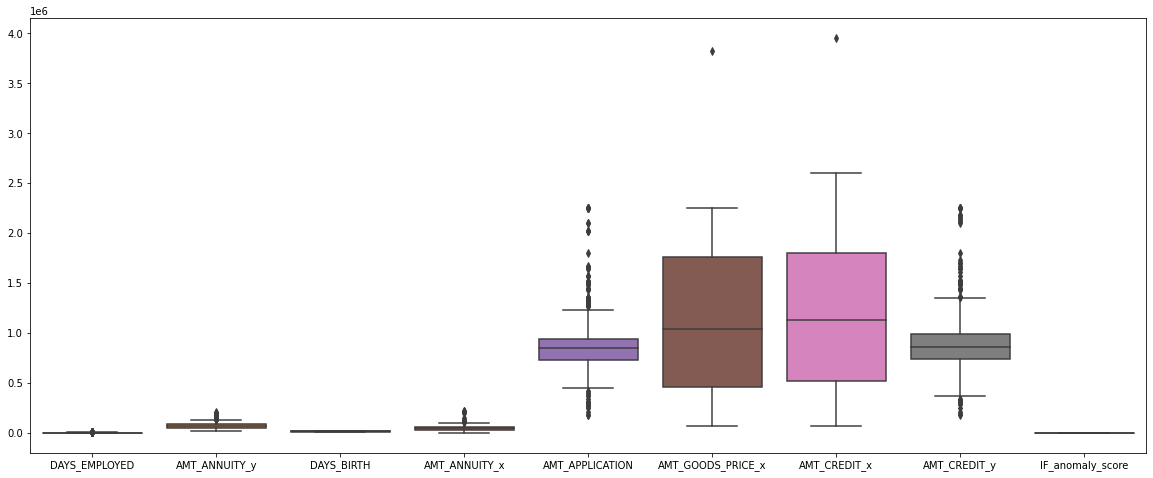

In [ ]:
# 이상치로 탐지된 데이터만 상자도표(boxplot) 시각화 -> 저차원에 적합한 시각화로 격리 포레스트 모델의 이상치 탐지 성능 평가에 적합하지 않음

f, axes = plt.subplots(ncols = 1, figsize = (20, 8))
sns.boxplot(data = NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1])

In [ ]:
# 3차원 축소(PCA) 후 시각화(PCA plot)

IF_PCA = PCA(n_components = 3)
# scaler = MinMaxScaler()
  # [탐지된 이상값을 이상치로 판정하기 위한 시각화를 위해 정규화를 시행하지 않음]

# NCB_IF = scaler.fit_transform(NCB_Isolation)
  # [normalize the metrics]
NCB_IF_reduction = IF_PCA.fit_transform(NCB_Isolation)

IF_PCA.explained_variance_ratio_.cumsum()
  # [주성분 1, 2, 3의 10개 연속형 변수에 대하여 설명가능한 분산의 누적 기여율]

array([0.92484758, 0.99323696, 0.99936978])

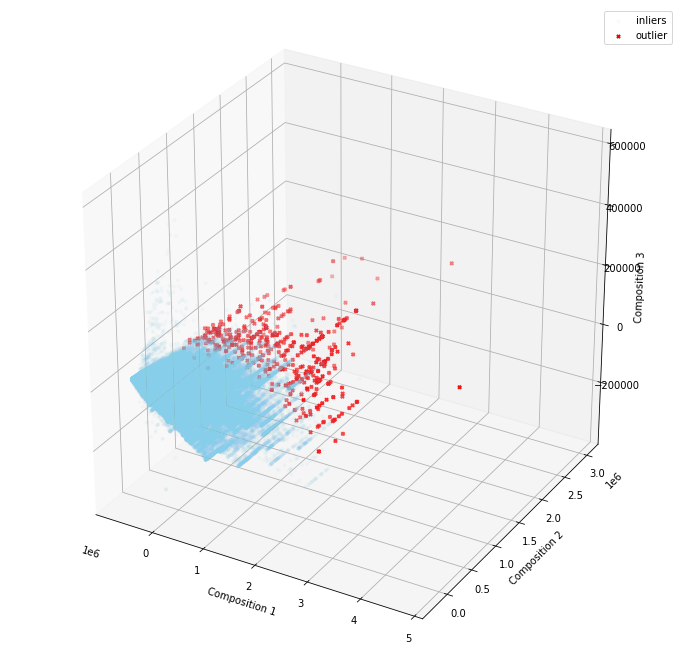

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")


ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction[:, 0],
           NCB_IF_reduction[:, 1],
           NCB_IF_reduction[:, 2],
           s = 8, lw = 1, alpha = 0.05, label = "inliers", c= "skyblue")

ax.scatter(NCB_IF_reduction[outlier_index, 0],
           NCB_IF_reduction[outlier_index, 1],
           NCB_IF_reduction[outlier_index, 2],
           s = 10, lw = 2, label = "outlier", c = "red", marker = "x")

ax.legend()
plt.show()

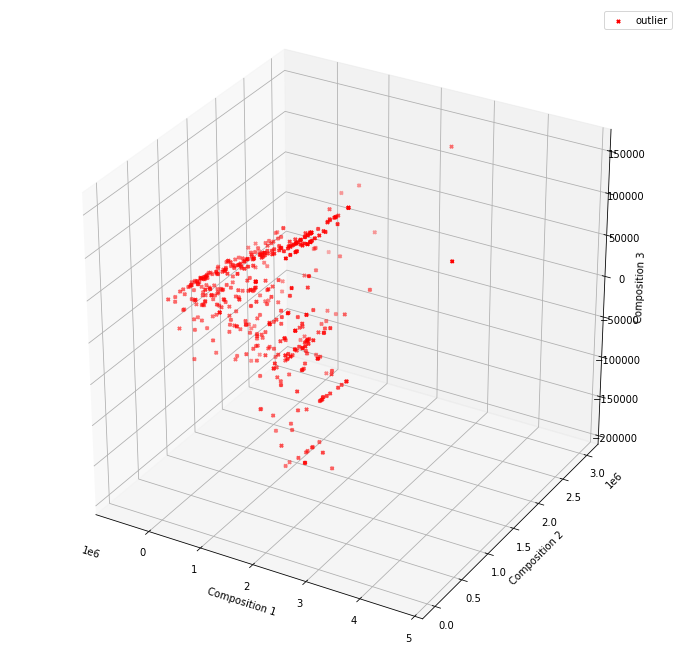

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction[outlier_index, 0],
           NCB_IF_reduction[outlier_index, 1],
           NCB_IF_reduction[outlier_index, 2],
           s = 10, lw = 2, label = "outlier", c = "red", marker = "x")

ax.legend()
plt.show()

In [ ]:
NCB_Isolation["TARGET"] = NCB_MICE_FS["TARGET"]

NCB_Isolation.TARGET.value_counts()
    # [이상치 25770개]

0    288205
1     25770
Name: TARGET, dtype: int64

In [ ]:
len(NCB_Isolation[(NCB_Isolation["TARGET"] == 1) & (NCB_Isolation["IF_anomaly_score"] == -1)])
  # [연체 위험(신용 리스크) 있는 고객의 관측값이 이상치로 탐지된 경우 25,770행 중 32행] -> 32

34

In [ ]:
len(NCB_Isolation[(NCB_Isolation["TARGET"] == 0) & (NCB_Isolation["IF_anomaly_score"] == -1)])
  # [우량 ~ 보통 신용등급 고객의 관측값이 이상치로 탐지된 경우  288,205행 중 443행] -> 423

422

In [ ]:
len(outlier_index)
    # [475]

456

In [ ]:
# 이상치 제거 및 파일 생성

NCB_MICE_FS.drop(outlier_index, axis = 0, inplace = True)

In [ ]:
NCB_MICE_FS.shape
    # [(313500, 129)]

(313519, 129)

In [ ]:
NCB_MICE_FS.to_csv("/content/drive/MyDrive/NCB_MICE_FS.csv", index = False)
  # [New Credit Bureau _ Impute NA with MICE _ Feature Selection with PCA, Filtering _ Outlier Detection with Isolation Forest]